In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2

normal_images = []
folder_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal"
normal_images = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if "_mask" not in filename]

folder_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
benign_images = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if "_mask" not in filename]

folder_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
malignant_images = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if "_mask" not in filename]


# each image is black and white : 500*500 dimensional

image = cv2.imread(normal_images[0])

print(len(normal_images))
print(len(benign_images))
print(len(malignant_images))
print(image.shape)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


133
437
210
(619, 761, 3)


In [2]:
# now we have to convert all to pixels

# converting all images to 128*128 in grayscale 
import cv2
import numpy as np

normal_matrices = []

for image_path in normal_images:
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (128,128))
    img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    normal_matrices.append(img)

benign_matrices = []

for image_path in benign_images:
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (128,128))
    img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    benign_matrices.append(img)
    
malignant_matrices = []

for image_path in malignant_images:
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (128,128))
    img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    malignant_matrices.append(img)
    
print(normal_matrices[0].shape)
    

(128, 128, 3)


In [3]:
# Normalize the data 

for i in normal_matrices:
    i = i / 255.0

for i in benign_matrices:
    i = i / 255.0
    
for i in malignant_matrices:
    i = i / 255.0
    

In [4]:
from sklearn.model_selection import train_test_split


# Concatenate the arrays vertically
all_images = np.concatenate((normal_matrices,benign_matrices,malignant_matrices))

# Create labels for the classes
class1_labels = np.zeros(len(normal_images), dtype=int)
class2_labels = np.ones(len(benign_images), dtype=int)
class3_labels = np.full(len(malignant_images), 2, dtype=int)

all_labels = np.concatenate((class1_labels, class2_labels, class3_labels))

# Split the data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

# Print the shapes of the train and test sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (624, 128, 128, 3)
Test images shape: (156, 128, 128, 3)
Train labels shape: (624,)
Test labels shape: (156,)


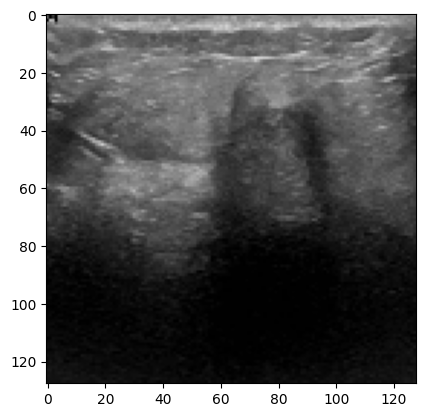

In [5]:
plt.imshow(train_images[0])

In [6]:
import tensorflow as tf
from tensorflow import keras 
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    hub.KerasLayer("https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2",
               trainable=True, arguments=dict(batch_norm_momentum=0.992)),
    tf.keras.layers.Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(0.01)),
])

model.build([624, 224, 224, None]) 

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (624, 2048)               23564800  
                                                                 
 dense (Dense)               (624, 3)                  6147      
                                                                 
Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
_________________________________________________________________
None


In [7]:
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    # from logits : appyling softmax to the 1D vector 
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ["accuracy"]
)

model.fit(train_images,train_labels,batch_size = 64,epochs = 10,verbose = 2)

Epoch 1/10
10/10 - 46s - loss: 1.3522 - accuracy: 0.4808 - 46s/epoch - 5s/step
Epoch 2/10
10/10 - 2s - loss: 0.7555 - accuracy: 0.8862 - 2s/epoch - 185ms/step
Epoch 3/10
10/10 - 2s - loss: 0.5499 - accuracy: 0.9760 - 2s/epoch - 185ms/step
Epoch 4/10
10/10 - 2s - loss: 0.4542 - accuracy: 0.9952 - 2s/epoch - 185ms/step
Epoch 5/10
10/10 - 2s - loss: 0.4008 - accuracy: 1.0000 - 2s/epoch - 186ms/step
Epoch 6/10
10/10 - 2s - loss: 0.3734 - accuracy: 1.0000 - 2s/epoch - 185ms/step
Epoch 7/10
10/10 - 2s - loss: 0.3569 - accuracy: 1.0000 - 2s/epoch - 185ms/step
Epoch 8/10
10/10 - 2s - loss: 0.3443 - accuracy: 1.0000 - 2s/epoch - 186ms/step
Epoch 9/10
10/10 - 2s - loss: 0.3378 - accuracy: 1.0000 - 2s/epoch - 185ms/step
Epoch 10/10
10/10 - 2s - loss: 0.3322 - accuracy: 1.0000 - 2s/epoch - 185ms/step


In [8]:
model.evaluate(test_images,test_labels,batch_size = 64,verbose = 2)

3/3 - 2s - loss: 2.7049 - accuracy: 0.5449 - 2s/epoch - 629ms/step


[2.7048912048339844, 0.5448718070983887]

In [9]:
# Testing on single images

test_image = cv2.imread("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (101).png")
resized_image = cv2.resize(test_image, (128,128))
img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
print(img.shape)
pred = model.predict(img)

max_index = np.argmax(pred[0])

print(pred)

if(max_index == 0):
    print("Prediction : Normal")
elif max_index == 1:
    print("Prediction : benign")
else:
    print("Prediction : malignant")

(1, 128, 128, 3)
1/1 [==============================] - 1s 1s/step
[[3.6705060e-05 9.9381363e-01 6.1495998e-03]]
Prediction : benign


**
On Running 3 epochs :-
Accuracy on train data = 97%
Accuracy on test data = 52%

On Running 10 epochs :-
6th pe hi 100% accuracy 

loss is reduced alot but still very high
accuracy increase only 2%

model is overfitting : we need to add regularizers?

To fine tune more we can :

->increase learnable params
->play with learning rate 
->add regularizers 
->change optimizer algorithm?

So literally we need to do the same things with SAM as well
to get accuracy in SAM 

but that is not a simple CNN 
that is a complex architecture 

have to see what changes in model have to be done rather 
than simple last layer removal

